# COVID-19 Remote Sensing Fusion

## Exploring Black Marble Imagery at Penn State

## Environment Setup

Pseudocode

* Import packages
    * Work with shapefiles (geopandas)
    * Work with rasters (rasterio, earthpy)
* Set working directory
    * Set to home 
* Set environment settings
    * Plotting settings

In [1]:
# Import packages
import os
import re
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em

# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion"
)

In [3]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "radiance_files"
)

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv"
)

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF.csv"                         
)

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF.csv"                         
)

In [4]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\02-raw-data\radiance_files\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\02-raw-data\radiance_files\PSU_Radiance_RavelOrderF.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\02-raw-data\radiance_files\PSU_CloudMask_RavelOrderF.csv


## Data Preparation

Pseudocode

* Load study area boundary
    * Define file path
* Load imagery
    * Define file paths
    * Mask cloud
    * Mask no data values
    * Isolate/extract necessary bands
    * Stack imagery bands
* Clip imagery to study area boundary
    * Project study area boundary to CRS of imagery

### Read CSV Files to Geodataframes

In [5]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [6]:
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [7]:
# Read radience values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [8]:
psu_radiance_df.head()

,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-09-19,2019-09-20,2019-09-22,2019-09-23,2019-09-25,2019-09-26,2019-09-27,2019-09-28,2019-10-01,2019-10-02,2019-10-04,2019-10-05,2019-10-06,2019-10-08,2019-10-09,2019-10-10,2019-10-11,2019-10-12,2019-10-13,2019-10-14,2019-10-15,2019-10-17,2019-10-18,2019-10-19,2019-10-20,2019-10-21,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-30,2019-11-01,2019-11-02,2019-11-03,2019-11-05,2019-11-06,2019-11-08,2019-11-09,2019-11-10,2019-11-11,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-27,2019-11-28,2019-11-29,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-25,2020-04-26,2020-04-27,2020-04-28
0,12,6,9,7,14,7,7,16,10,35,103,194,34,38,22,22,24,11,88,6,10,9,11,7,10,8,6,15,9,47,11,22,33,37,86,41,110,73,20,57,25,16,14,8,146,24,7,9,10,12,10,10,19,7,14,19,46,148,116,34,98,29,52,24,13,11,13,3,7,21,16,19,16,33,17,5,14,27,18,33,86,92,176,132,116,185,155,70,68,21,18,17,8,25,6,11,12,11,25,9,8,14,10,9,12,11,17,45,88,116,157,254,225,57,70,18,30,36,24,20,22,17,23,53,9,25,7,13,8,11,14,7,11,4,35,67,61,227,353,294,152,43,82,41,10,30,12,7,10,10,12,12,6,6,16,13,17,16,15,8,10,13,13,15,18,122,38,95,189,33,47,65,17,23,11,6,11,6,3,10,9,6,7,1,6,5,10,6,24,7,9,6,4,14
1,11,6,9,7,14,15,11,16,18,44,103,194,34,45,22,32,24,13,88,27,18,9,11,9,10,18,25,15,9,47,24,22,37,39,86,41,113,73,20,61,25,16,22,13,146,28,7,15,12,12,20,29,20,16,20,18,51,151,116,102,104,44,52,24,22,11,13,3,12,21,22,19,16,33,27,4,17,27,18,41,100,95,190,132,123,175,155,70,71,28,19,17,7,25,8,17,17,11,25,9,9,20,81,9,10,19,17,47,88,119,157,242,233,57,76,26,35,50,25,31,43,17,29,56,10,23,9,20,16,11,21,7,11,59,35,62,62,227,353,293,159,44,83,40,10,34,12,7,10,15,12,12,17,9,18,14,17,16,26,54,20,16,13,29,30,124,41,95,189,45,50,66,18,24,11,8,12,6,3,10,22,7,7,1,13,5,10,7,24,10,14,4,7,17
2,11,6,17,18,35,60,11,15,18,41,105,197,50,98,42,32,31,14,31,27,44,18,85,7,18,16,25,17,15,24,24,48,51,133,86,36,109,73,20,61,35,14,19,23,16,28,7,15,12,19,20,31,20,46,20,18,75,153,118,102,104,44,58,31,18,19,29,3,16,27,29,30,17,35,41,4,17,34,25,41,100,96,189,133,133,175,147,74,69,32,29,19,7,15,31,17,17,14,36,5,11,21,81,9,10,19,19,47,98,162,158,242,239,89,76,26,35,50,25,89,43,81,29,56,10,25,9,20,16,40,21,7,14,27,42,62,62,243,359,293,160,48,83,43,18,34,12,7,31,19,25,38,17,9,18,14,19,26,26,54,36,16,16,154,92,132,44,96,193,45,61,66,91,25,23,9,12,4,6,12,22,9,18,2,20,7,9,7,40,11,15,4,7,17
3,11,7,66,95,35,60,116,15,135,54,105,202,168,98,106,108,62,97,92,116,44,166,181,17,59,15,57,17,15,24,50,29,44,133,86,36,109,73,176,66,72,14

In [9]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [10]:
psu_cloud_mask_df.head()

,9/1/2019,9/2/2019,9/3/2019,9/4/2019,9/5/2019,9/6/2019,9/7/2019,9/8/2019,9/11/2019,9/12/2019,9/13/2019,9/14/2019,9/15/2019,9/17/2019,9/18/2019,9/19/2019,9/20/2019,9/22/2019,9/23/2019,9/25/2019,9/26/2019,9/27/2019,9/28/2019,10/1/2019,10/2/2019,10/4/2019,10/5/2019,10/6/2019,10/8/2019,10/9/2019,10/10/2019,10/11/2019,10/12/2019,10/13/2019,10/14/2019,10/15/2019,10/17/2019,10/18/2019,10/19/2019,10/20/2019,10/21/2019,10/22/2019,10/23/2019,10/24/2019,10/25/2019,10/26/2019,10/27/2019,10/28/2019,10/30/2019,11/1/2019,11/2/2019,11/3/2019,11/5/2019,11/6/2019,11/8/2019,11/9/2019,11/10/2019,11/11/2019,11/14/2019,11/15/2019,11/16/2019,11/17/2019,11/18/2019,11/19/2019,11/21/2019,11/22/2019,11/23/2019,11/24/2019,11/25/2019,11/27/2019,11/28/2019,11/29/2019,12/1/2019,12/2/2019,12/3/2019,12/4/2019,12/5/2019,12/6/2019,12/7/2019,12/8/2019,12/9/2019,12/10/2019,12/11/2019,12/12/2019,12/13/2019,12/14/2019,12/15/2019,12/16/2019,12/17/2019,12/20/2019,12/21/2019,12/22/2019,12/23/2019,12/24/2019,12/25/2019,12/26/2019,12/27/2019,12/28/2019,12/29/2019,12/30/2019,12/31/2019,1/1/2020,1/2/2020,1/3/2020,1/4/2020,1/5/2020,1/6/2020,1/7/2020,1/8/2020,1/9/2020,1/10/2020,1/11/2020,1/12/2020,1/13/2020,1/14/2020,1/15/2020,1/16/2020,1/17/2020,1/18/2020,1/19/2020,1/20/2020,1/21/2020,1/22/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/8/2020,2/9/2020,2/10/2020,2/11/2020,2/12/2020,2/13/2020,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020,3/25/2020,3/26/2020,3/27/2020,3/28/2020,3/29/2020,3/30/2020,3/31/2020,4/25/2020,4/26/2020,4/27/2020,4/28/2020
0,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,1,100,100,100,100,100,100,1,100,100,1,100,100,100,1,100,100,100,100,100,1,100,100,100,100,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,1,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
1,100,100,1,1,1,1,1,1,1,100,100,100,1,100,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,100,100,100,100,100,100,100,1,100,1,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,100,1,1,100,100,100,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
2,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,1,1,100,1,1,1,100,100,100,1,100,1,100,100,1,100,1,100,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,1,100,100,100,100,100,100,100,1,1,1,1,100,100,100,100,100,100,100,1,100,100,1,100,100,1,100,100,100,100,1,100,1,100,100,100,1,1,1,1,100,100,100,100,100,100,1,100,100,100,1,100,100,100,100,100,100,100,100,100,100,1,100,100,100,100,1,1,1,1,1,100,1,100,1,1,1,1,100,100,1,1,100,1,100,100,1,100,100,1,100,1,100,100,100,100,100,1,100,100,100,100,100,100,100,1,100,100,100,100,100
3,100,100,1,1,1,1,1,1,1,100,100,100,1,1,1,1,100,1,1,1,1,1,1,100,1,1,1,100,100,100,1,1,100,1,1,1,100,100,1,100,100,100,1,1,1,100,100,1,100,100,

### Isolate Single-Day Radiance and Cloud Mask

In [11]:
# Get single day radiances
radiance_sept_15_2019_df = psu_radiance_df[['2019-09-15']]
radiance_mar_22_2020_df = psu_radiance_df[['2020-03-22']]

# Get single day cloud masks
cloud_mask_sept_15_2019_df = psu_cloud_mask_df[['9/15/2019']]
cloud_mask_mar_22_2020_df = psu_cloud_mask_df[['3/22/2020']]

In [12]:
# Create radiance array, with pixels aligned to the correct position
radiance_sept_15_2019_arr = radiance_sept_15_2019_df.to_numpy().reshape((40,18)).transpose()
radiance_mar_22_2020_arr = radiance_mar_22_2020_df.to_numpy().reshape((40,18)).transpose()

# Create cloud mask arrays
cloud_mask_sept_15_2019_arr = cloud_mask_sept_15_2019_df.to_numpy().reshape((40,18)).transpose()
cloud_mask_mar_22_2020_arr = cloud_mask_mar_22_2020_df.to_numpy().reshape((40,18)).transpose()

In [13]:
# Get min and max radiance values
print(f"Max radiance (9/15/2019): {radiance_sept_15_2019_arr.max()}")
print(f"Min radiance (9/15/2019): {radiance_sept_15_2019_arr.min()}\n")

print(f"Max radiance (3/22/2020): {radiance_mar_22_2020_arr.max()}")
print(f"Min radiance (3/22/2020): {radiance_mar_22_2020_arr.min()}")

Max radiance (9/15/2019): 1121
Min radiance (9/15/2019): 26

Max radiance (3/22/2020): 1274
Min radiance (3/22/2020): 2


### Plot Cloud Masks - Sept 15, 2019

In [14]:
# Get unique value in cloud mask array
np.unique(cloud_mask_sept_15_2019_arr).tolist()
np.unique(cloud_mask_mar_22_2020_arr).tolist()

[1]

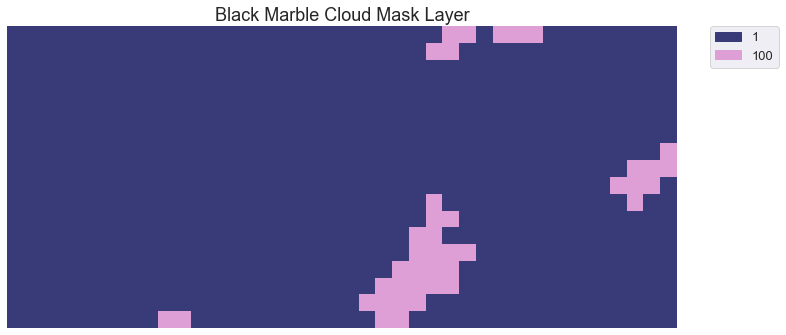

In [15]:
# This is optional code to plot the qa layer - don't worry too much about the details.
# Create a colormap with 11 colors
cmap = plt.cm.get_cmap('tab20b', 2)
# Get a list of unique values in the qa layer
vals = np.unique(cloud_mask_sept_15_2019_arr).tolist()
bins = [0] + vals
# Normalize the colormap 
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(cloud_mask_sept_15_2019_arr,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap, titles=vals)

ax.set_title("Black Marble Cloud Mask Layer")
ax.set_axis_off()
plt.show()


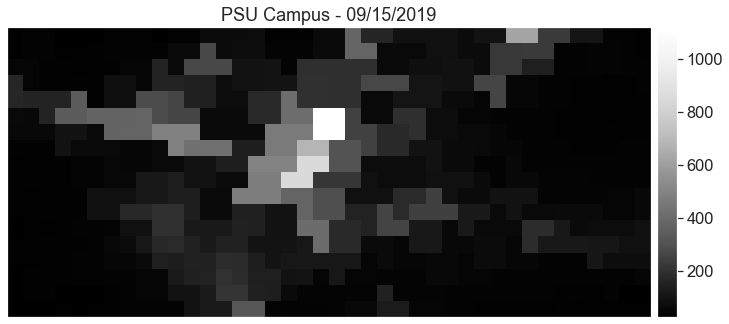

In [16]:
# Plot radiance values (NOT MASKED) for Sept 15, 2019
ep.plot_bands(
    radiance_sept_15_2019_arr, title="PSU Campus - 09/15/2019", scale=False)

In [17]:
# Define mask values
masked_vals = [100]

# Mask radiance
# Call the earthpy mask function using pixel QA layer
radiance_sept_15_2019_cloud_free = em.mask_pixels(
    radiance_sept_15_2019_arr, 
    cloud_mask_sept_15_2019_arr, 
    vals=masked_vals)

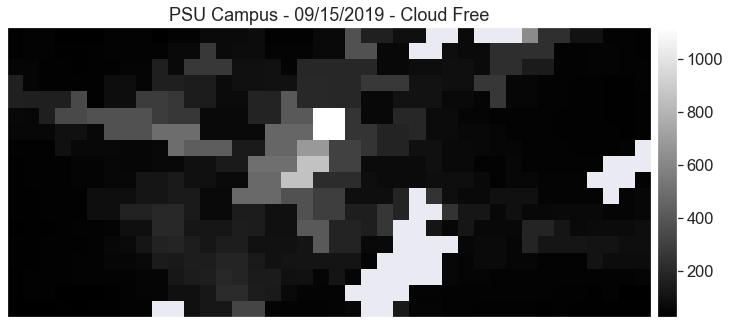

In [18]:
# Plot radiance values (MASKED) for Sept 15, 2019  
# HOW TO SHOW MASKED IN A DIFFERENCE COLOR 
ep.plot_bands(
    radiance_sept_15_2019_cloud_free, 
    cmap='gist_gray',
    title="PSU Campus - 09/15/2019 - Cloud Free", 
    scale=False)

In [19]:
# radiance_sept_15_2019_cloud_free

In [20]:
radiance_sept_15_2019_cloud_free.fill_value

999999

In [21]:
# Set fill value (masked pixels) to a value of 0 (for plotting)
#  Otherwise it will e an extreme and trow off the plot
ma.set_fill_value(radiance_sept_15_2019_cloud_free, 0)

In [22]:
radiance_sept_15_2019_cloud_free.fill_value

0

In [23]:
radiance_filled_0 = ma.filled(radiance_sept_15_2019_cloud_free)

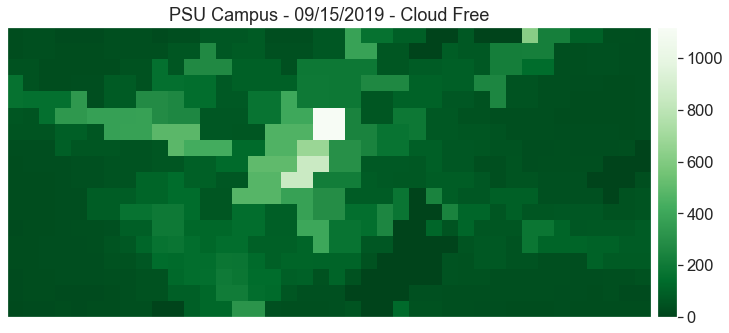

In [24]:
ep.plot_bands(
    radiance_filled_0, 
    cmap='Greens_r',
    title="PSU Campus - 09/15/2019 - Cloud Free", 
    scale=False,)

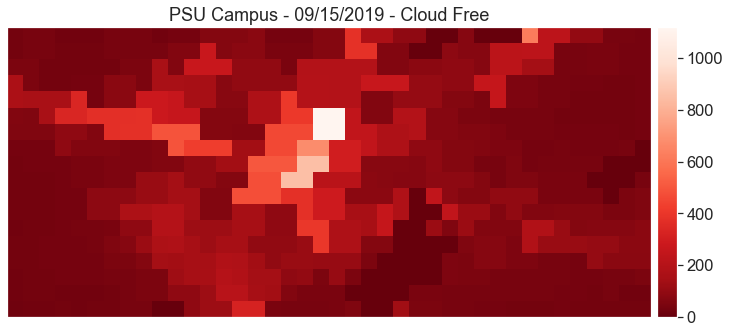

In [25]:
# Plot radiance values (MASKED) for Sept 15, 2019
ep.plot_bands(
    radiance_filled_0, 
    cmap='Reds_r',
    title="PSU Campus - 09/15/2019 - Cloud Free", 
    scale=False,
    vmin=0)

In [26]:
# cl_mask = em._create_mask(cloud_mask_sept_15_2019_arr, [100])

# # Call the earthpy mask function using your mask layer
# cl_free = em.mask_pixels(cloud_mask_sept_15_2019_arr, cl_mask)



### Plot Cloud Masks - Mar 22, 2020

In [27]:
# Get unique value in cloud mask array
np.unique(cloud_mask_sept_15_2019_arr).tolist()
np.unique(cloud_mask_mar_22_2020_arr).tolist()

[1]

In [28]:
# # This is optional code to plot the qa layer - don't worry too much about the details.
# # Create a colormap with 11 colors
# cmap = plt.cm.get_cmap('tab20b', 1)
# # Get a list of unique values in the qa layer
# vals = np.unique(cloud_mask_mar_22_2020_arr).tolist()
# bins = [0] + vals
# # Normalize the colormap 
# bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
#     [(bins[-1] - bins[-2]) + bins[-1]]
# norm = colors.BoundaryNorm(bounds, cmap.N)

# # Plot the data
# fig, ax = plt.subplots(figsize=(12, 8))

# im = ax.imshow(cloud_mask_mar_22_2020_arr,
#                cmap=cmap,
#                norm=norm)

# ep.draw_legend(im,
#                classes=vals,
#                cmap=cmap, titles=vals)

# ax.set_title("Black Marble Cloud Mask Layer")
# ax.set_axis_off()
# plt.show()


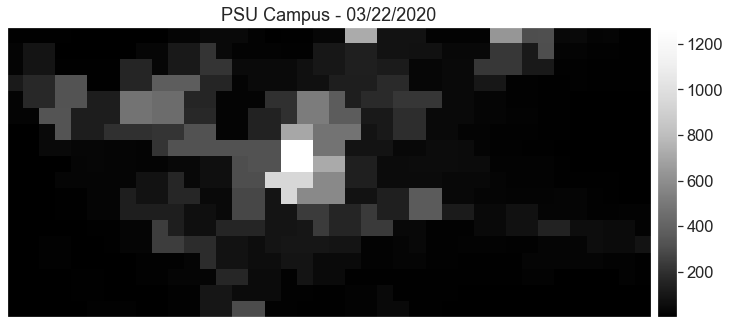

In [29]:
# Plot radiance values (NOT MASKED) for Sept 15, 2019
ep.plot_bands(
    radiance_mar_22_2020_arr, title="PSU Campus - 03/22/2020", scale=False)

In [30]:
# Define mask values # No masked values here... Need to create conditional to handle
masked_vals = [100]

# Mask radiance
# Call the earthpy mask function using pixel QA layer
# radiance_mar_22_2020_cloud_free = em.mask_pixels(
#     radiance_mar_22_2020_arr, 
#     cloud_mask_mar_22_2020_arr, 
#     vals=masked_vals)

radiance_mar_22_2020_cloud_free = radiance_mar_22_2020_arr

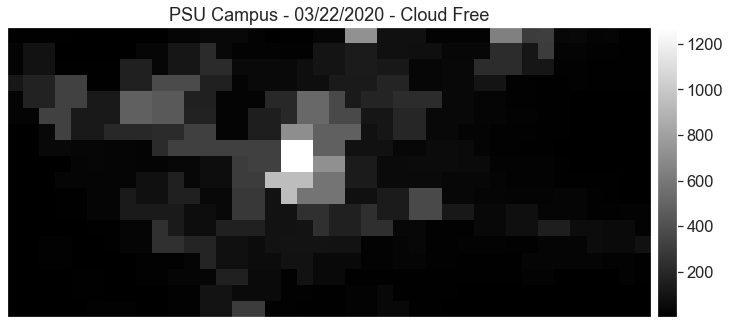

In [31]:
# Plot radiance values (MASKED) for Sept 15, 2019  
# HOW TO SHOW MASKED IN A DIFFERENCE COLOR 
ep.plot_bands(
    radiance_mar_22_2020_cloud_free, 
    cmap='gist_gray',
    title="PSU Campus - 03/22/2020 - Cloud Free", 
    scale=False)

In [32]:
# radiance_sept_15_2019_cloud_free

In [33]:
# radiance_sept_15_2019_cloud_free.fill_value

In [34]:
# # Set fill value (masked pixels) to a value of 0 (for plotting)
# #  Otherwise it will e an extreme and trow off the plot
# ma.set_fill_value(radiance_sept_15_2019_cloud_free, 0)

In [35]:
# radiance_sept_15_2019_cloud_free.fill_value

In [36]:
# radiance_filled_0 = ma.filled(radiance_sept_15_2019_cloud_free)

In [37]:
# ep.plot_bands(
#     radiance_filled_0, 
#     cmap='Greens_r',
#     title="PSU Campus - 09/15/2019 - Cloud Free", 
#     scale=False,)

In [38]:
# # Plot radiance values (MASKED) for Sept 15, 2019
# ep.plot_bands(
#     radiance_filled_0, 
#     cmap='Reds_r',
#     title="PSU Campus - 09/15/2019 - Cloud Free", 
#     scale=False,
#     vmin=0)

In [39]:
# ma.masked_array(radiance_sept_15_2019_arr, cl_mask)

In [40]:
# a = ma.masked_where(radiance_sept_15_2019_arr, cloud_mask_sept_15_2019_arr==100)

In [ ]:
# a

### Histograms of Cloud Free Radiance

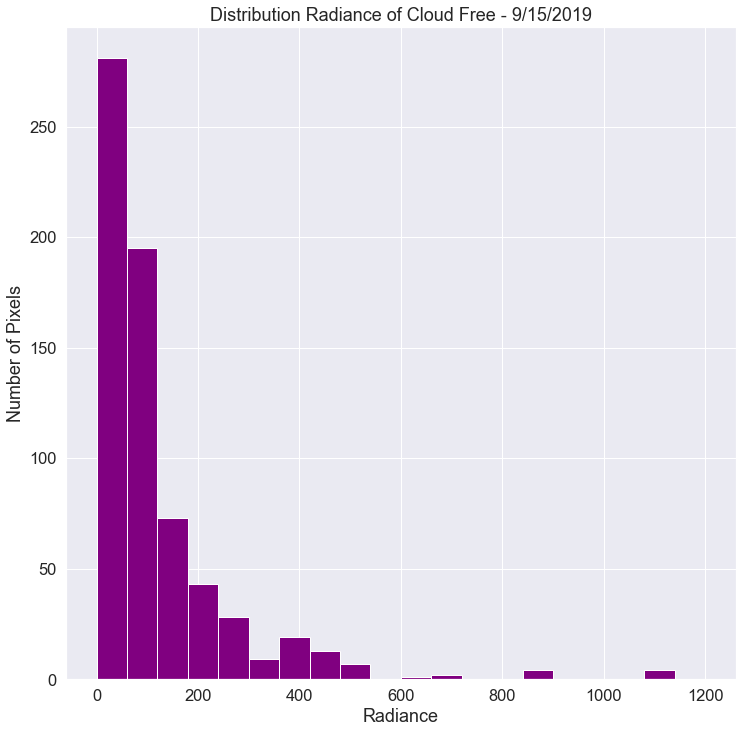

In [41]:
# September 15, 2019
ep.hist(
    radiance_sept_15_2019_cloud_free.ravel(),
    title="Distribution Radiance of Cloud Free - 9/15/2019",
    xlabel="Radiance",
    ylabel="Number of Pixels",
    hist_range=(0, 1200))


plt.show()

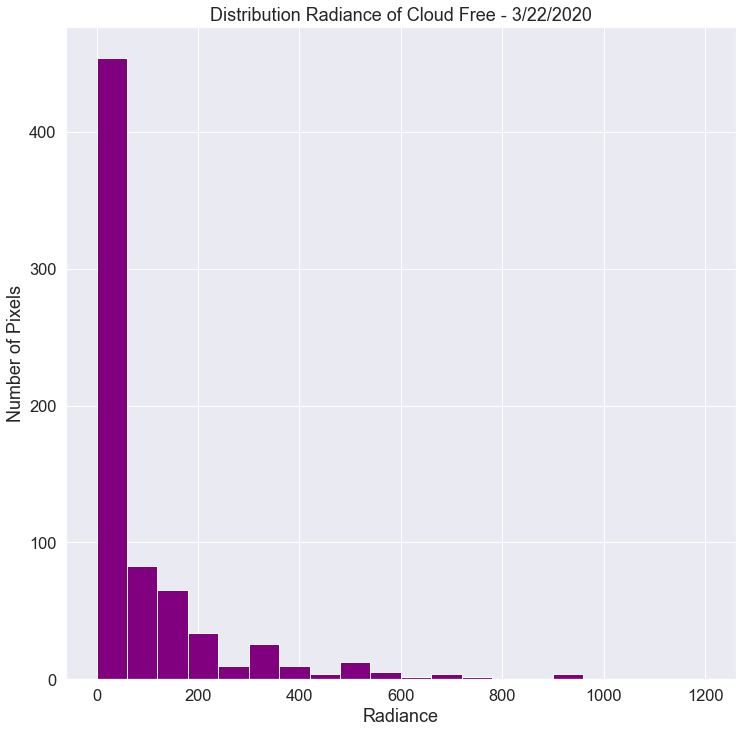

In [42]:
# March 22, 2020
ep.hist(
    radiance_mar_22_2020_cloud_free.ravel(),
    title="Distribution Radiance of Cloud Free - 3/22/2020",
    xlabel="Radiance",
    ylabel="Number of Pixels",
    hist_range=(0, 1200))


plt.show()

In [43]:
# Average radiance
radiance_sept_15_2019_cloud_free.mean()

124.4300441826215

In [44]:
# Average radiance
radiance_mar_22_2020_cloud_free.mean()

101.775

In [45]:
# # Median radiance
# np.median(radiance_sept_15_2019_cloud_free)

In [46]:
from scipy import stats as st

In [47]:
st.describe(radiance_sept_15_2019_cloud_free, axis=None)._asdict()

OrderedDict([('nobs', 720),
             ('minmax', (26, 1121)),
             ('mean', 124.4300441826215),
             ('variance', 21255.962281856457),
             ('skewness', 3.4619244846528723),
             ('kurtosis', 16.22214033091068)])

In [48]:
st.describe(radiance_mar_22_2020_cloud_free, axis=None)

DescribeResult(nobs=720, minmax=(2, 1274), mean=101.775, variance=28995.053616133515, skewness=3.483252373478032, kurtosis=15.884372727731886)

### Compute difference

In [49]:
masked_difference = radiance_mar_22_2020_cloud_free - radiance_sept_15_2019_cloud_free

In [50]:
masked_difference.min()

-748

In [51]:
masked_difference.max()

810

In [52]:
# masked_difference

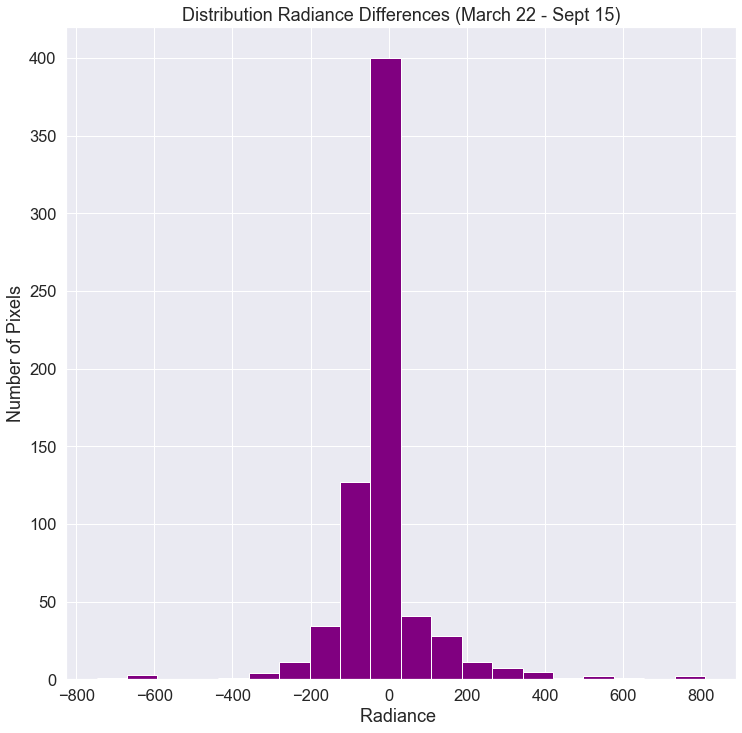

In [53]:
# March 22, 2020
ep.hist(
    masked_difference.ravel(),
    title="Distribution Radiance Differences (March 22 - Sept 15)",
    xlabel="Radiance ",
    ylabel="Number of Pixels",
    hist_range=(masked_difference.min(), masked_difference.max()))


plt.show()

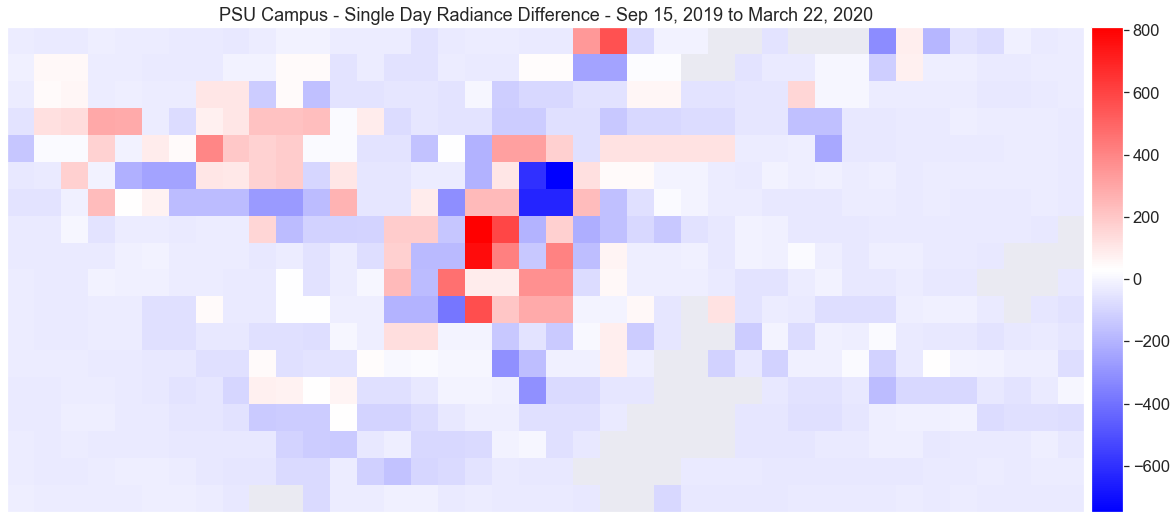

In [54]:
ep.plot_bands(masked_difference, title="PSU Campus - Single Day Radiance Difference - Sep 15, 2019 to March 22, 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='bwr',
              figsize=(20,10),
              scale=False, vmin=masked_difference.min(), vmax=masked_difference.max())#, vmax=1000)

plt.show()

### Get Plotting Extent

In [55]:
psu_lat_lon_df

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355
5,5,40.809084,-77.937355
6,6,40.804917,-77.937355
7,7,40.800751,-77.937355
8,8,40.796584,-77.937355
9,9,40.792417,-77.937355


In [56]:
from rasterio.plot import plotting_extent

In [57]:
lon_min = psu_lat_lon_df.Longitude.min()
lon_max = psu_lat_lon_df.Longitude.max()
lat_min = psu_lat_lon_df.Latitude.min()
lat_max = psu_lat_lon_df.Latitude.max()

In [58]:
print("Lon min:", lon_min)
print("Lon max:", lon_max)
print("Lat min:", lat_min)
print("Lat max:", lat_max)

Lon min: -77.93735504
Lon max: -77.77485504
Lat min: 40.75908399
Lat max: 40.82991733


In [59]:
# Create padding for extent (assume lat/lon are centroids)
padding = (lat_max - lat_min) / 17

# Define extent
psu_extent = (lon_min-0.004166999999995369/2, 
              lon_max+0.004166999999995369/2, 
              lat_min-0.004166999999995369/2, 
              lat_max+0.004166999999995369/2)

In [60]:
padding

0.004166667058823534

In [61]:
psu_extent

(-77.93943854, -77.77277154000001, 40.75700049, 40.83200083)

In [62]:
# psu_lat_lon_gdf

NameError: name 'psu_lat_lon_gdf' is not defined

In [63]:
# Create geodataframe to store lat/lon points (for plotting over change grid)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [64]:
0.004166999999995369 # lat dis

0.004166999999995369

In [65]:
psu_lat_lon_gdf

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)
5,5,40.809084,-77.937355,POINT (-77.93736 40.80908)
6,6,40.804917,-77.937355,POINT (-77.93736 40.80492)
7,7,40.800751,-77.937355,POINT (-77.93736 40.80075)
8,8,40.796584,-77.937355,POINT (-77.93736 40.79658)
9,9,40.792417,-77.937355,POINT (-77.93736 40.79242)


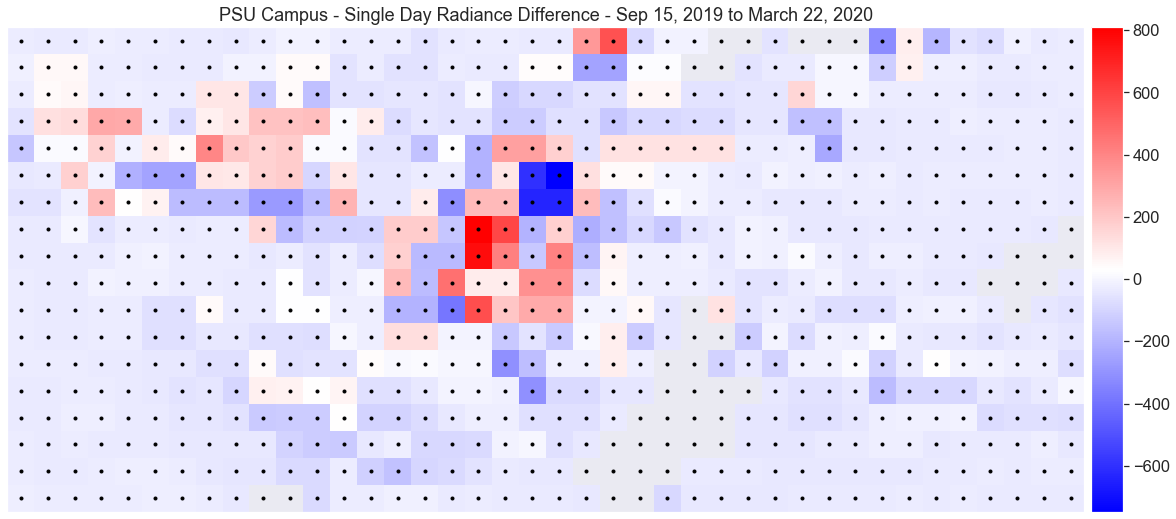

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(masked_difference, title="PSU Campus - Single Day Radiance Difference - Sep 15, 2019 to March 22, 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='bwr',
              #figsize=(20,10),
              scale=False, vmin=masked_difference.min(), vmax=masked_difference.max(),
              extent=psu_extent, ax=ax)#, vmax=1000)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# ax.set_axis_on()

plt.show()

Join based on pixel id

### September Average vs. March Average

In [67]:
for col in psu_radiance_df.columns: 
    if '2019-09' in col:
        print(col) 

2019-09-01
2019-09-02
2019-09-03
2019-09-04
2019-09-05
2019-09-06
2019-09-07
2019-09-08
2019-09-11
2019-09-12
2019-09-13
2019-09-14
2019-09-15
2019-09-17
2019-09-18
2019-09-19
2019-09-20
2019-09-22
2019-09-23
2019-09-25
2019-09-26
2019-09-27
2019-09-28


In [68]:
# List of radiance dataframes in September
sept_2019_list = [psu_radiance_df[[col]]
                  for col in psu_radiance_df.columns if '2019-09' in col]

In [69]:
len(sept_2019_list)

23

In [70]:
type(sept_2019_list[0])

pandas.core.frame.DataFrame

In [71]:
sept_2019_list[0].columns[0]

'2019-09-01'

In [72]:
# Function to extract radiance and cloud mask data into correclty shaped array
def get_psu_array(radiance_df):
    return radiance_df.to_numpy().reshape((40,18)).transpose()

In [73]:
# List of numpy arrays for radiance values
sept_2019_array_list = list(map(get_psu_array, sept_2019_list))

In [74]:
len(sept_2019_array_list)

23

In [75]:
type(sept_2019_array_list[0])

numpy.ndarray

In [76]:
sept_2019_array_list[0].shape

(18, 40)

In [77]:
# Stack arrays for all days (3d array)
sept_2019_stack = np.stack(sept_2019_array_list)

In [78]:
sept_2019_stack.shape

(23, 18, 40)

In [79]:
sept_2019_stack[0].shape

(18, 40)

In [80]:
# Get mean value for all arrays into one (should result in single 2d array)
np.mean(sept_2019_stack, axis=0).shape

(18, 40)

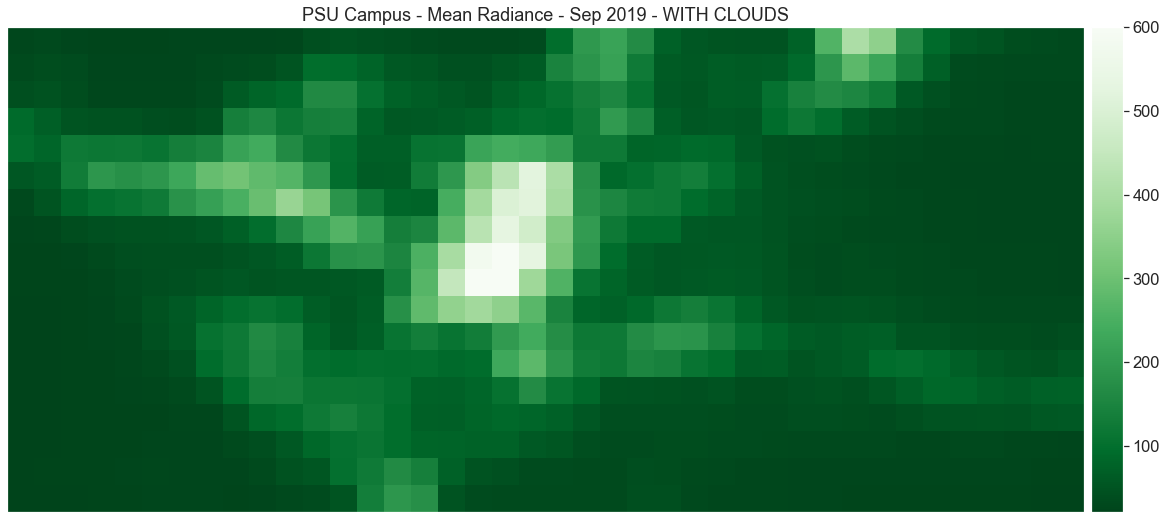

In [81]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(np.mean(sept_2019_stack, axis=0), title="PSU Campus - Mean Radiance - Sep 2019 - WITH CLOUDS", 
              cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              #cmap='bwr',
              #figsize=(20,10),
              scale=False, #vmin=masked_difference.min(), vmax=masked_difference.max(),
              extent=psu_extent, ax=ax,
              vmax=600)#, vmax=1000)

In [82]:
# List of radiance dataframes in September
mar_2020_list = [psu_radiance_df[[col]]
                  for col in psu_radiance_df.columns if '2020-03' in col]

In [83]:
len(mar_2020_list)

31

In [84]:
type(mar_2020_list[0])

pandas.core.frame.DataFrame

In [85]:
mar_2020_list[0].columns[0]

'2020-03-01'

In [86]:
# List of numpy arrays for radiance values
mar_2020_array_list = list(map(get_psu_array, mar_2020_list))

In [87]:
len(mar_2020_array_list)

31

In [88]:
type(mar_2020_array_list[0])

numpy.ndarray

In [89]:
mar_2020_array_list[0].shape

(18, 40)

In [90]:
# Stack arrays for all days (3d array)
mar_2020_stack = np.stack(mar_2020_array_list)

In [91]:
mar_2020_stack.shape

(31, 18, 40)

In [92]:
mar_2020_stack[0].shape

(18, 40)

In [93]:
# Get mean value for all arrays into one (should result in single 2d array)
np.mean(mar_2020_stack, axis=0).shape

(18, 40)

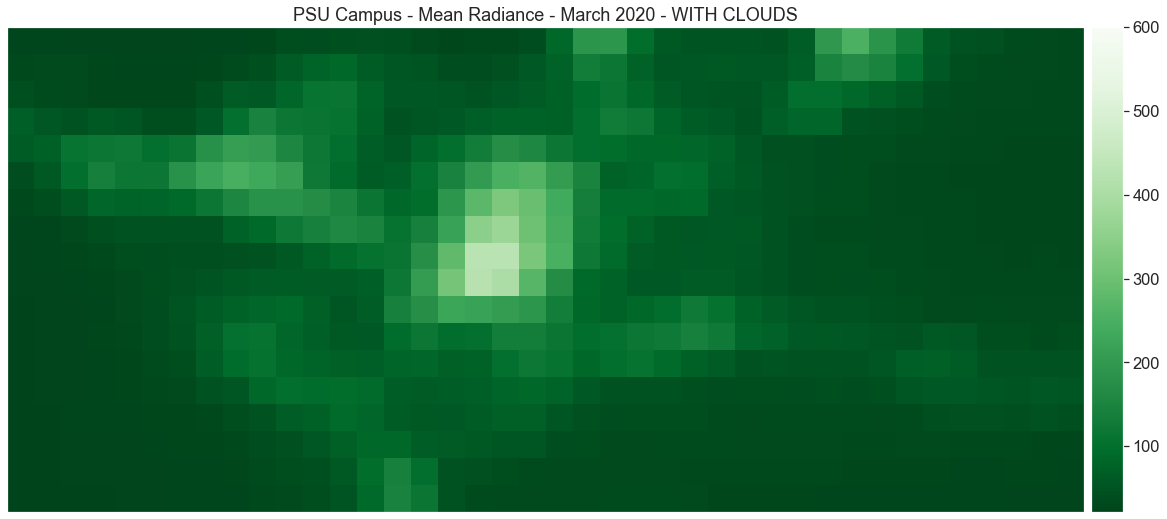

In [94]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(np.mean(mar_2020_stack, axis=0), title="PSU Campus - Mean Radiance - March 2020 - WITH CLOUDS", 
              cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              #cmap='bwr',
              #figsize=(20,10),
              scale=False, #vmin=masked_difference.min(), vmax=masked_difference.max(),
              extent=psu_extent, ax=ax,
              vmax=600)#, vmax=1000)

In [95]:
# Compute mean for stacked arrays (mean for each pixel)
sep_2019_mean = np.mean(sept_2019_stack, axis=0)
mar_2020_mean = np.mean(mar_2020_stack, axis=0)

In [96]:
# Difference in mean at each pixel
sep_to_march_diff_mean = mar_2020_mean - sep_2019_mean

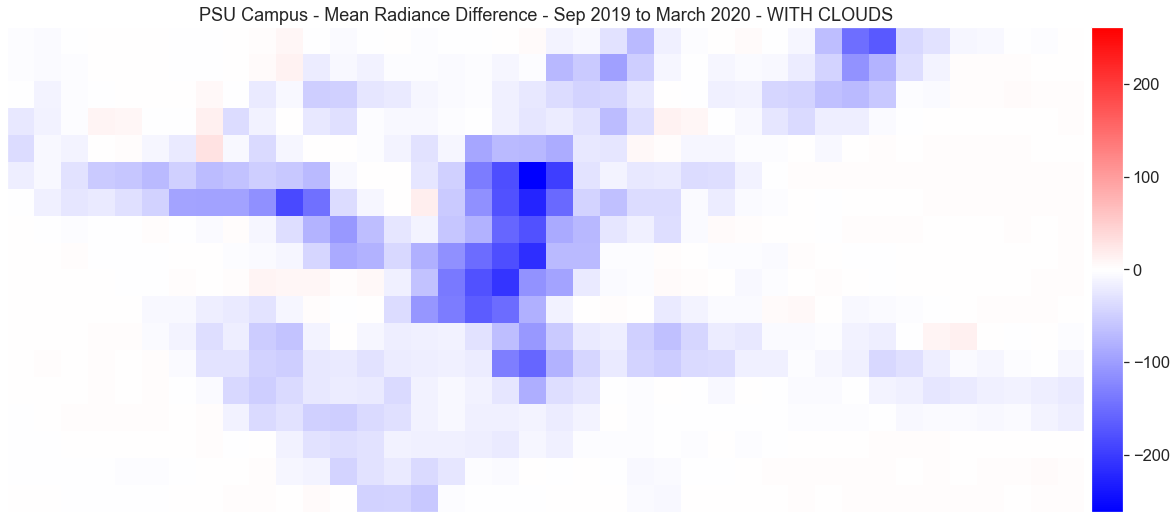

In [97]:
# Plot
ep.plot_bands(sep_to_march_diff_mean, title="PSU Campus - Mean Radiance Difference - Sep 2019 to March 2020 - WITH CLOUDS", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='bwr',
              figsize=(20,10),
              scale=False, vmin=sep_to_march_diff_mean.min(),
              vmax=-sep_to_march_diff_mean.min())# vmin=masked_difference.min(), vmax=masked_difference.max())#, vmax=1000)

plt.show()

### Include Cloud Masks in Mean Calculation - Sep

Get list radiance values (df or array)
    * Map get_psu_array if for arrays
Get list of mask values (df or array)
    * Map get_psu_array if for arrays
Zip lists together to tuple

For each tuple in the list:
    * If 100 in tuple[0]
        * Create masked array on tuple[0] masking with tuple[1]
        * Append masked array to new list
    * Else
        * Append tuple[0] to new list
    
Stack list of masked arrays
Compute mean 

In [98]:
# Setp 2019 radiance
sept_2019_rad_list = [psu_radiance_df[[col]]
                      for col in psu_radiance_df.columns if '2019-09' in col]

# Setp 2019 cloud mask
sept_2019_mask_list = [psu_cloud_mask_df[[col]]
                       for col in psu_cloud_mask_df.columns if re.compile("^9/*.{2}/2019$").match(col)]

In [99]:
# List of numpy arrays
sept_2019_rad_array_list = list(map(get_psu_array, sept_2019_rad_list))
sept_2019_mask_array_list = list(map(get_psu_array, sept_2019_mask_list))

In [100]:
# Zip lists
sep_2019_zip = list(zip(sept_2019_rad_array_list, sept_2019_mask_array_list))

In [101]:
len(sep_2019_zip)

23

In [102]:
sep_radiance_masked_list = []

for rad_mask_tuple in sep_2019_zip:

    # Check if array should be masked
    if 100 in rad_mask_tuple[1]:

        # Mask
        rad_cloud_free = em.mask_pixels(
            rad_mask_tuple[0],
            rad_mask_tuple[1],
            vals=[100])
        
        sep_radiance_masked_list.append(rad_cloud_free)
        
    else:
        
        # Append original (cloud-free) array
        sep_radiance_masked_list.append(rad_mask_tuple[0])

In [103]:
len(sep_radiance_masked_list)

23

In [104]:
# Create stack
sep_2019_stack_cloud_free = np.stack(sep_radiance_masked_list)

In [105]:
sep_2019_stack_cloud_free.shape

(23, 18, 40)

In [106]:
# Get mean value for all arrays into one (should result in single 2d array)
sep_2019_cloud_free_mean = np.mean(sep_2019_stack_cloud_free, axis=0)

In [107]:
sep_2019_cloud_free_mean.shape

(18, 40)

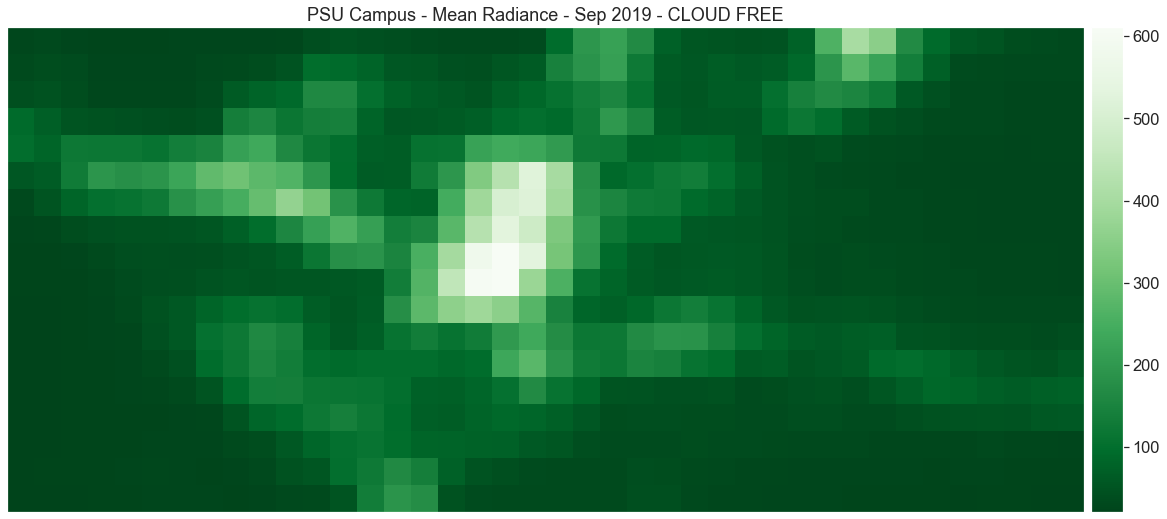

In [108]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(sep_2019_cloud_free_mean, title="PSU Campus - Mean Radiance - Sep 2019 - CLOUD FREE", 
              cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              #cmap='bwr',
              #figsize=(20,10),
              scale=False, #vmin=masked_difference.min(), vmax=masked_difference.max(),
              extent=psu_extent, ax=ax)
              #vmax=600)#, vmax=1000)

### Include Cloud Masks in Mean Calculation - March

Get list radiance values (df or array)
    * Map get_psu_array if for arrays
Get list of mask values (df or array)
    * Map get_psu_array if for arrays
Zip lists together to tuple

For each tuple in the list:
    * If 100 in tuple[0]
        * Create masked array on tuple[0] masking with tuple[1]
        * Append masked array to new list
    * Else
        * Append tuple[0] to new list
    
Stack list of masked arrays
Compute mean 

In [109]:
# March 2020 radiance
march_2020_rad_list = [psu_radiance_df[[col]]
                      for col in psu_radiance_df.columns if '2020-03' in col]

# March 2020 cloud mask
march_2020_mask_list = [psu_cloud_mask_df[[col]]
                       for col in psu_cloud_mask_df.columns if re.compile("^3/*.{2}/2020$").match(col)]

In [110]:
# List of numpy arrays
march_2020_rad_array_list = list(map(get_psu_array, march_2020_rad_list))
march_2020_mask_array_list = list(map(get_psu_array, march_2020_mask_list))

In [111]:
# Zip lists
march_2020_zip = list(zip(march_2020_rad_array_list, march_2020_mask_array_list))

In [112]:
len(march_2020_zip)

31

In [113]:
march_radiance_masked_list = []

for rad_mask_tuple in march_2020_zip:

    # Check if array should be masked
    if 100 in rad_mask_tuple[1]:

        # Mask
        rad_cloud_free = em.mask_pixels(
            rad_mask_tuple[0],
            rad_mask_tuple[1],
            vals=[100])
        
        march_radiance_masked_list.append(rad_cloud_free)
        
    else:
        
        # Append original (cloud-free) array
        march_radiance_masked_list.append(rad_mask_tuple[0])

In [114]:
len(march_radiance_masked_list)

31

In [115]:
# Create stack
march_2020_stack_cloud_free = np.stack(march_radiance_masked_list)

In [116]:
march_2020_stack_cloud_free.shape

(31, 18, 40)

In [117]:
# Get mean value for all arrays into one (should result in single 2d array)
march_2020_cloud_free_mean = np.mean(march_2020_stack_cloud_free, axis=0)

In [118]:
march_2020_cloud_free_mean.shape

(18, 40)

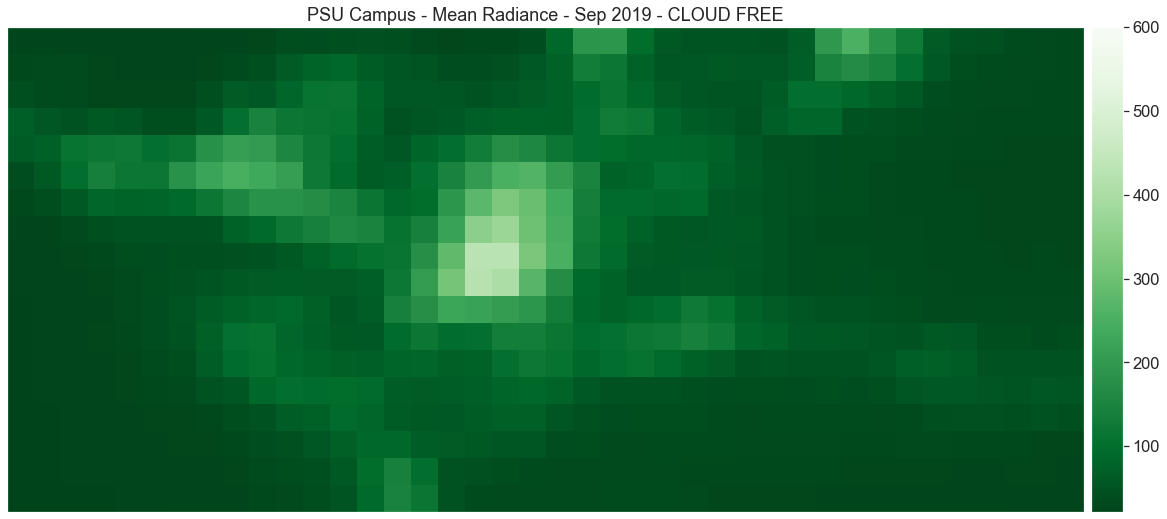

In [119]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(march_2020_cloud_free_mean, title="PSU Campus - Mean Radiance - Sep 2019 - CLOUD FREE", 
              cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              #cmap='bwr',
              #figsize=(20,10),
              scale=False, #vmin=masked_difference.min(), vmax=masked_difference.max(),
              extent=psu_extent, ax=ax, vmax=600)
              #vmax=600)#, vmax=1000)

In [120]:
# Difference in mean at each pixel
cloud_free_mean_diff = march_2020_cloud_free_mean - sep_2019_cloud_free_mean

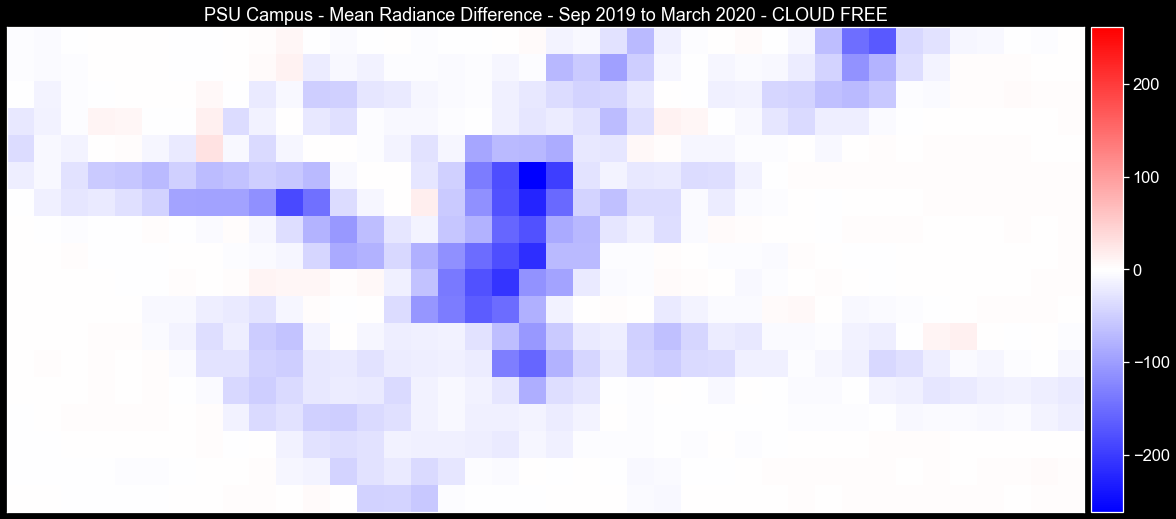

In [121]:
# Plot
with plt.style.context('dark_background'):

    ep.plot_bands(
        cloud_free_mean_diff, title="PSU Campus - Mean Radiance Difference - Sep 2019 to March 2020 - CLOUD FREE",
        # cmap='Greens_r',
        # cmap='RdYlBu_r',
        # cmap='coolwarm',
        cmap='bwr',
        figsize=(20, 10),
        scale=False,
        vmin=sep_to_march_diff_mean.min(),
        vmax=-sep_to_march_diff_mean.min())  # vmin=masked_difference.min(), vmax=masked_difference.max())#, vmax=1000)

    #ax.set_ylabel("Cadence\n(steps/minute)")
    
    plt.show()

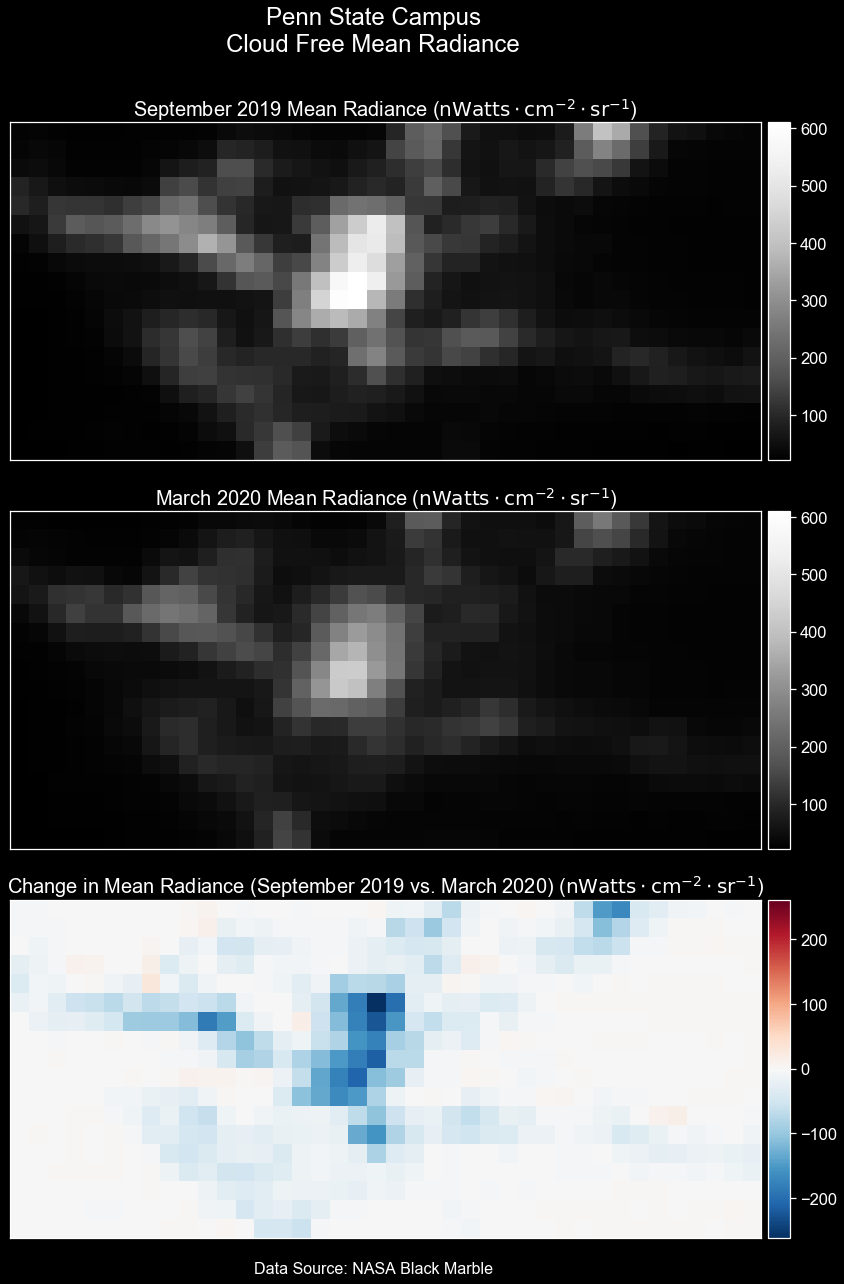

In [157]:
#%matplotlib inline

# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        sep_2019_cloud_free_mean, title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        # cmap='Greens_r',
        # cmap='RdYlBu_r',
        # cmap='coolwarm',
        # cmap='bwr',
        # figsize=(20, 10),
        scale=False,
        vmax=sep_2019_cloud_free_mean.max(),
        ax=ax[0],
        extent=psu_extent)  # vmin=masked_difference.min(), vmax=masked_difference.max())#, vmax=1000)

    ep.plot_bands(
        march_2020_cloud_free_mean, title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        # cmap='Greens_r',
        # cmap='RdYlBu_r',
        # cmap='coolwarm',
        # cmap='bwr',
        # figsize=(20, 10),
        scale=False,
        vmax=sep_2019_cloud_free_mean.max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        cloud_free_mean_diff, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        # cmap='Greens_r',
        # cmap='RdYlBu_r',
        # cmap='coolwarm',
        cmap='RdBu_r',
        #cmap='bwr',
        #cmap='seismic',
        # cmap='PiYG',
        # figsize=(20, 10),
        scale=False,
        vmin=cloud_free_mean_diff.min(),
        vmax=-cloud_free_mean_diff.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

    # ax.set_ylabel("Cadence\n(steps/minute)")

    #plt.show()

plt.savefig(fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", facecolor='k',
        #fname=os.path.join(working_directory, '04-graphics-output", "penn-state-mean-radiance-difference-march-2020-september-2019.png'),
                dpi=300, transparent=True, bbox_inches='tight')

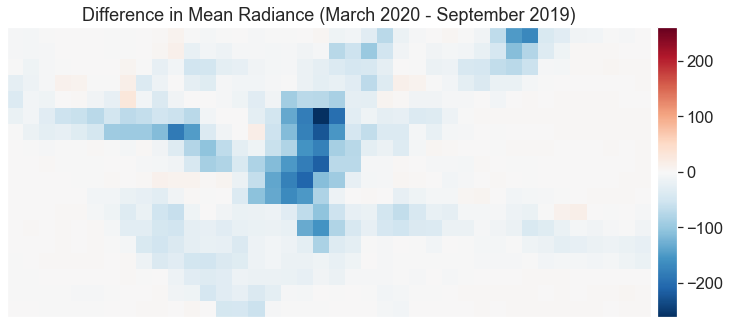

In [155]:
ep.plot_bands(
    cloud_free_mean_diff, title="Difference in Mean Radiance (March 2020 - September 2019)",
    # cmap='Greens_r',
    # cmap='RdYlBu_r',
    #cmap='coolwarm',
    cmap='RdBu_r',
    # cmap='bwr',
    #cmap='seismic',
    #cmap='PiYG',
    #figsize=(20, 10),
    scale=False,
    vmin=cloud_free_mean_diff.min(),
    vmax=-cloud_free_mean_diff.min(),
    extent=psu_extent)

plt.show()

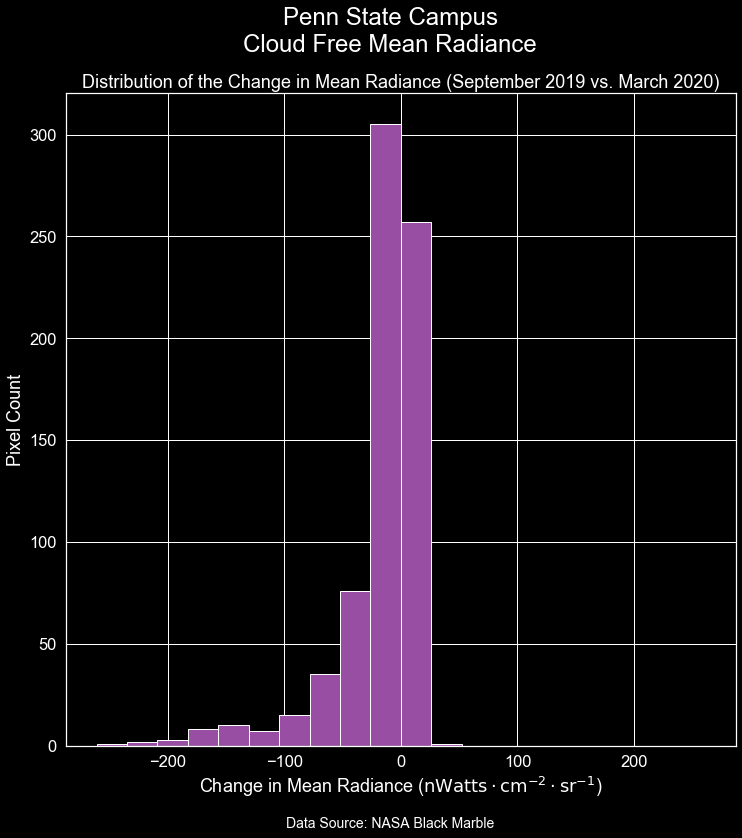

In [161]:
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        cloud_free_mean_diff,
        #         bins=40,
        hist_range=(cloud_free_mean_diff.min(), -cloud_free_mean_diff.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

#     ax.title.set_size(20)

plt.savefig(fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", facecolor='k',
            #fname=os.path.join(working_directory, '04-graphics-output", "penn-state-mean-radiance-difference-march-2020-september-2019.png'),
            dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# df_merge = psu_lat_lon_df.merge(psu_radiance_df[['2019-09-15']], on="ID")
# df_merge_2 = psu_lat_lon_df.merge(psu_radiance_df[['2020-04-25']], on="ID")

In [ ]:
# df_merge

In [ ]:
# df_copy = df_merge.copy()

# df_merge_gdf = gpd.GeoDataFrame(
#     df_merge.copy(), 
#     crs="epsg:4326", 
#     geometry=gpd.points_from_xy(
#         df_copy.Longitude, 
#         df_copy.Latitude)
# )

In [ ]:
# df_copy_2 = df_merge_2.copy()

# df_merge_gdf_2 = gpd.GeoDataFrame(
#     df_merge_2.copy(), 
#     crs="epsg:4326", 
#     geometry=gpd.points_from_xy(
#         df_copy_2.Longitude, 
#         df_copy_2.Latitude)
# )

In [ ]:
# df_merge_gdf

In [ ]:
df_merge_gdf_2

In [ ]:
df_merge_gdf.plot()

In [ ]:
# Number of Longitude points (x values)
df_merge_gdf.Longitude.unique().shape

In [ ]:
# Number of Latitude points (y values)
df_merge_gdf.Latitude.unique().shape

Grid size of 40 (x) by 20 (y)
Need to get numpy array with 40x20 (reshape)

In [ ]:
# Convert single date to 1d matrix
df_merge_gdf['2019-09-15'].to_numpy()#.shape

In [ ]:
# Convert single date to 1d matrix
df_merge_gdf['2019-09-15'].to_numpy().reshape((40,18))

In [ ]:
df_merge_gdf['2019-09-15'].to_numpy().reshape((18,40)).shape

In [ ]:
df_merge_gdf['2019-09-15'].to_numpy().reshape((18,40))[0]

In [ ]:
# Get the transposed matrix to line up with lat/lon
df_merge_gdf['2019-09-15'].to_numpy().reshape((40,18)).transpose()

In [ ]:
single_day_radiance = df_merge_gdf['2019-09-15'].to_numpy().reshape((40,18)).transpose()
single_day_radiance_2 = df_merge_gdf_2['2020-04-25'].to_numpy().reshape((40,18)).transpose()

In [ ]:
df_merge_gdf['2019-09-15'].to_numpy().reshape((40,18)).transpose().shape

In [ ]:
# from matplotlib.pyplot import *
# from scipy import mgrid

# def imsave(filename, X, **kwargs):
#     """ Homebrewed imsave to have nice colors... """
#     figsize=(array(X.shape)/100.0)[::-1]
#     rcParams.update({'figure.figsize':figsize})
#     fig = figure(figsize=figsize)
#     axes([0,0,1,1]) # Make the plot occupy the whole canvas
#     axis('off')
#     fig.set_size_inches(figsize)
#     imshow(X,origin='lower', **kwargs)
#     savefig(filename, facecolor='black', edgecolor='black', dpi=100)
#     close(fig)


# X,Y=mgrid[-5:5:0.1,-5:5:0.1]
# Z=sin(X**2+Y**2+1e-4)/(X**2+Y**2+1e-4) # Create the data to be plotted
# imsave('imsave.png', Z, cmap=cm.hot )

# NEED TO MASK VALUES

Which value should be masked? 1 or 100?

# ADD PLOTTING EXTENT

From Geodataframe

In [ ]:
ep.plot_bands(single_day_radiance, title="PSU Campus - 09/15/2019", #cmap='RdYlBu',
              scale=False)

In [ ]:
ep.plot_bands(single_day_radiance_2, title="PSU Campus - 04/25/2020", #cmap='RdYlBu',
              scale=False)#, vmax=1000)

In [ ]:
diff_apr2020_sep2019 = single_day_radiance_2 - single_day_radiance

In [ ]:
ep.plot_bands(diff_apr2020_sep2019, title="PSU Campus - Difference - Sep 2019 to April 2020", 
              #cmap='Greens_r',
              #cmap='RdYlBu_r',
              #cmap='coolwarm',
              cmap='bwr',
              figsize=(20,10),
              scale=False, vmin=diff_apr2020_sep2019.min(), vmax=-diff_apr2020_sep2019.min())#, vmax=1000)

In [ ]:
ep.hist(single_day_radiance.ravel(),
        title="Distribution Radiance Data - 9/15/2019",
        xlabel="Radiance",
        ylabel="Number of Pixels",
        hist_range=(0, 1200))


plt.show()


In [ ]:
ep.hist(single_day_radiance_2.ravel(),
        title="Distribution Radiance Data - 4/25/2020",
        xlabel="Radiance",
        ylabel="Number of Pixels",
        hist_range=(0,1200))

plt.show()

In [ ]:
ep.hist(diff_apr2020_sep2019.ravel(),
        title="Distribution Radiance Data - Difference",
        xlabel="Radiance",
        ylabel="Number of Pixels",
        hist_range=(-1200,1200))

plt.show()

## Data Processing

Pseudocode

* Determine light change (single image)
    * Subtract pre-change image from post-change image
    * Positive change means increased light
    * Negative change means decreased light
* Determine light change (aggregate)
    * Create "baseline" average from previous timelines (Fall semester, Spring semester, Summer off-time semester, is there a J-term and/or specific summer months with activity?
    * May need to aggregate manually or download aggregations from GEE or NASA, and then compare a single day of the Spring 2020 semester (or aggregate of the Spring 2020 semester if available) to the averages for the Spring semester.

## Data Export

Pseudocode

* Save change images as GeoTiffs
    * Include metadata

## Data Visualization

Pseudocode

* Create plot showing pre-change image, post-change image, and the change raster
* Include color ramp with change raster
    * Diverging (change in both directions)
    * Show both continuous color map and discrete based on bins (% of max change)    

# General Notes/Conclusion

Document workflow

* What worked
* What didn't work
* Problems/issues with the workflow
* Problems/issues with the data